In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [2]:
RESULTS_DIR = "../results/jester_evaluation_v2"

In [3]:
p = Path(RESULTS_DIR)

In [4]:
pickle_paths = p.glob("./*.pickle")

In [5]:
reward_dict = {}
ndcg_dict = {}
time_dict = {}
for i, p in enumerate(pickle_paths):
    with open(p, "rb") as f:
        d = pickle.load(f)
    stats_dict = d[0][0]
    one_rew_dict = d[1]
    one_ndcg_dict = d[2]
    for key in one_rew_dict:
        rew_list = one_rew_dict[key]
        ndcg_list = one_ndcg_dict[key]
        mean_rew = np.mean(np.stack(rew_list), axis=0)
        mean_ndcg = np.mean(np.stack(ndcg_list), axis=0)
        reward_dict[key] = mean_rew
        ndcg_dict[key] = mean_ndcg
        assert key == stats_dict[0]
        time_dict[key] = stats_dict[1]['Time mean']

In [6]:
reward_dict

{'CBRAP (d=150, alpha=0.3)': array([[    0.],
        [    0.],
        [    0.],
        ...,
        [25080.],
        [25080.],
        [25081.]]),
 'BCMAB-RP (d=150, gamma=0.99, a=0.1)': array([[0.00000e+00],
        [2.00000e-01],
        [4.00000e-01],
        ...,
        [4.39452e+04],
        [4.39452e+04],
        [4.39462e+04]]),
 'RandomPolicy': array([[0.0000e+00],
        [0.0000e+00],
        [2.0000e-01],
        ...,
        [1.3989e+04],
        [1.3989e+04],
        [1.3989e+04]]),
 'LinearTS (nu=0.3)': array([[0.0000e+00],
        [2.0000e-01],
        [2.0000e-01],
        ...,
        [3.6993e+04],
        [3.6993e+04],
        [3.6994e+04]]),
 'CBRAP (d=300, alpha=0.3)': array([[    0. ],
        [    0. ],
        [    0. ],
        ...,
        [28870. ],
        [28870. ],
        [28870.8]]),
 'CBRAP (d=30, alpha=0.3)': array([[    0.],
        [    0.],
        [    0.],
        ...,
        [19918.],
        [19918.],
        [19918.]]),
 'BCMAB-RP (d=30, g

In [7]:
CHANGE_POINTS = [1, 5000, 10000, 20000, 35000, 50000, 65000, 80000, 90000, 100000]

## Plot the results

In [8]:
def plot_ndcg(cumulative_ndcg_dict):
    fig, ax = plt.subplots(1,1, figsize=(15,8));
    
    N = 1
    
    cumulative_ndcg_list = sorted(
        [
            (l,r) for l, r in cumulative_ndcg_dict.items()
        ],
        key=lambda x: x[1][-1],
        reverse=True,
    )
    
    for label, cumulative_ndcg in cumulative_ndcg_list:
        times = (range(1, len(cumulative_ndcg)+1))
        average_cumulative_ndcg = [cn/t for cn,t in zip(cumulative_ndcg, times)]
        ax.plot(average_cumulative_ndcg[N:], label=label)
        
    ax.set_xlabel('Trial')
    ax.set_ylabel('Average Cumulative NDCG@5')
    ax.set_title('Average Cumulative NDCG@5 on Jester')

    plt.legend(bbox_to_anchor=(1.00, 1.0));
    plt.savefig(f'jester_results_ndcg', dpi=300, facecolor=fig.get_facecolor(), bbox_inches='tight');
    plt.show();

In [9]:
def plot_ctrs_or_rewards(reward_dict, plot_type, change_points):
    if plot_type not in {'CTR', 'Cumulative reward'}:
        raise ValueError("plot_type should be CTR or Cumulative reward")
    fig, ax = plt.subplots(1,1, figsize=(15,8));
    N = 1
    sorted_reward_list = sorted(
        [
            (l,r) for l, r in reward_dict.items()
        ],
        key=lambda x: x[1][-1],
        reverse=True,
    )
    
    # Find out largest value. Do this first so change points appear first in the legend.
    max_vline = 0
    for ind, (label, reward) in enumerate(sorted_reward_list):
        times = (range(1, len(reward)+1))
        
        rewards = [r for r,t in zip(reward, times)]
        ctr = [r/t for r,t in zip(reward, times)]
        if plot_type == 'CTR':
            to_plot = ctr
        else:
            to_plot = rewards
        max_vline=max(max_vline, max(to_plot[N:]))
            
        ax.plot(to_plot[N:], label=label)
        
    reward_change_points = change_points[1:-1]
    plt.vlines(
        reward_change_points, ymin=0, ymax=max_vline, alpha=0.45
    )    
     
    extraticks = change_points
    plt.xticks(extraticks, rotation=20)
#     plt.yticks(fontsize=25)
    
    ax.set_xlabel('Trial')
    ax.set_ylabel(f'{plot_type}')

    plt.legend(bbox_to_anchor=(1.00, 1.0));
    
    plot_name = 'ctr' if plot_type == "CTR" else 'reward'
    plt.savefig(f'jester_results_{plot_name}', dpi=300, facecolor=fig.get_facecolor(), bbox_inches='tight');
    plt.show();

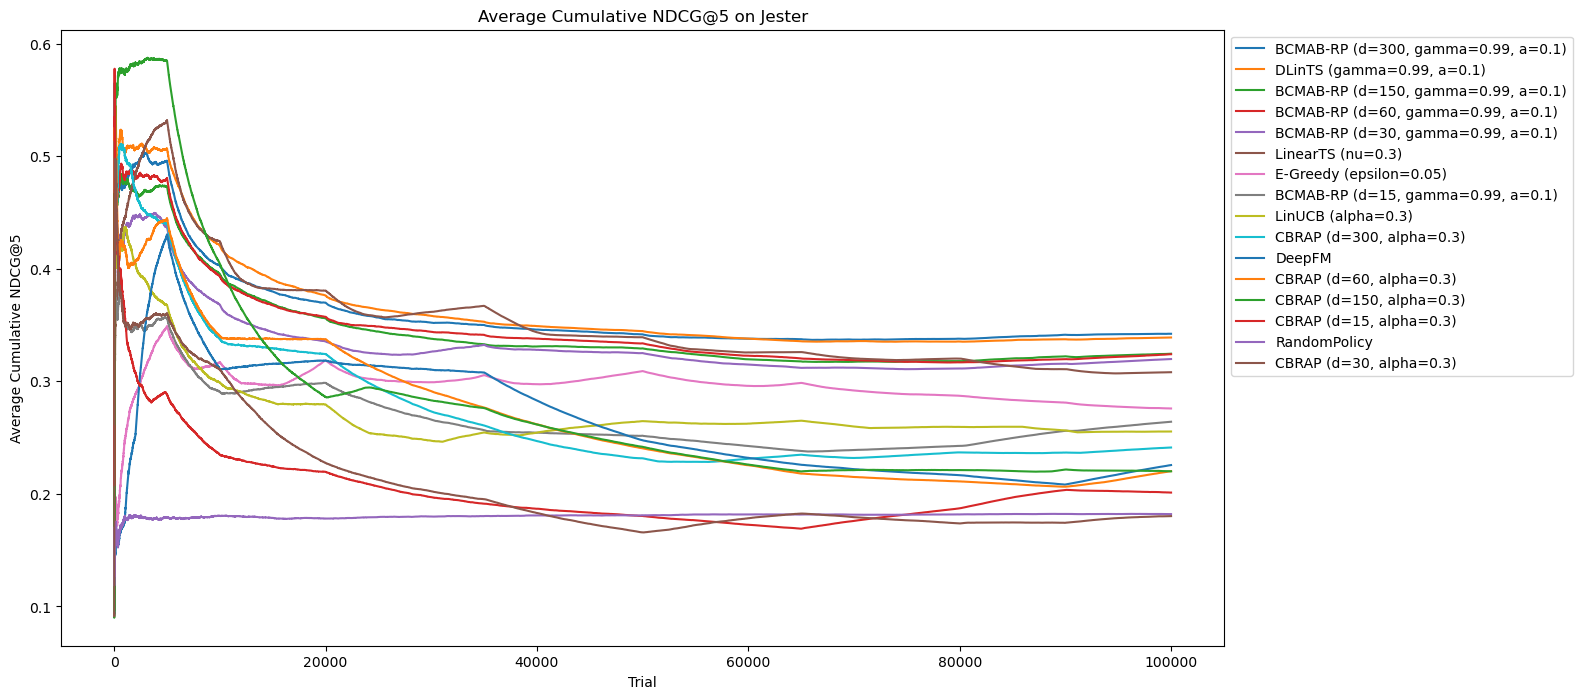

In [10]:
plot_ndcg(ndcg_dict)

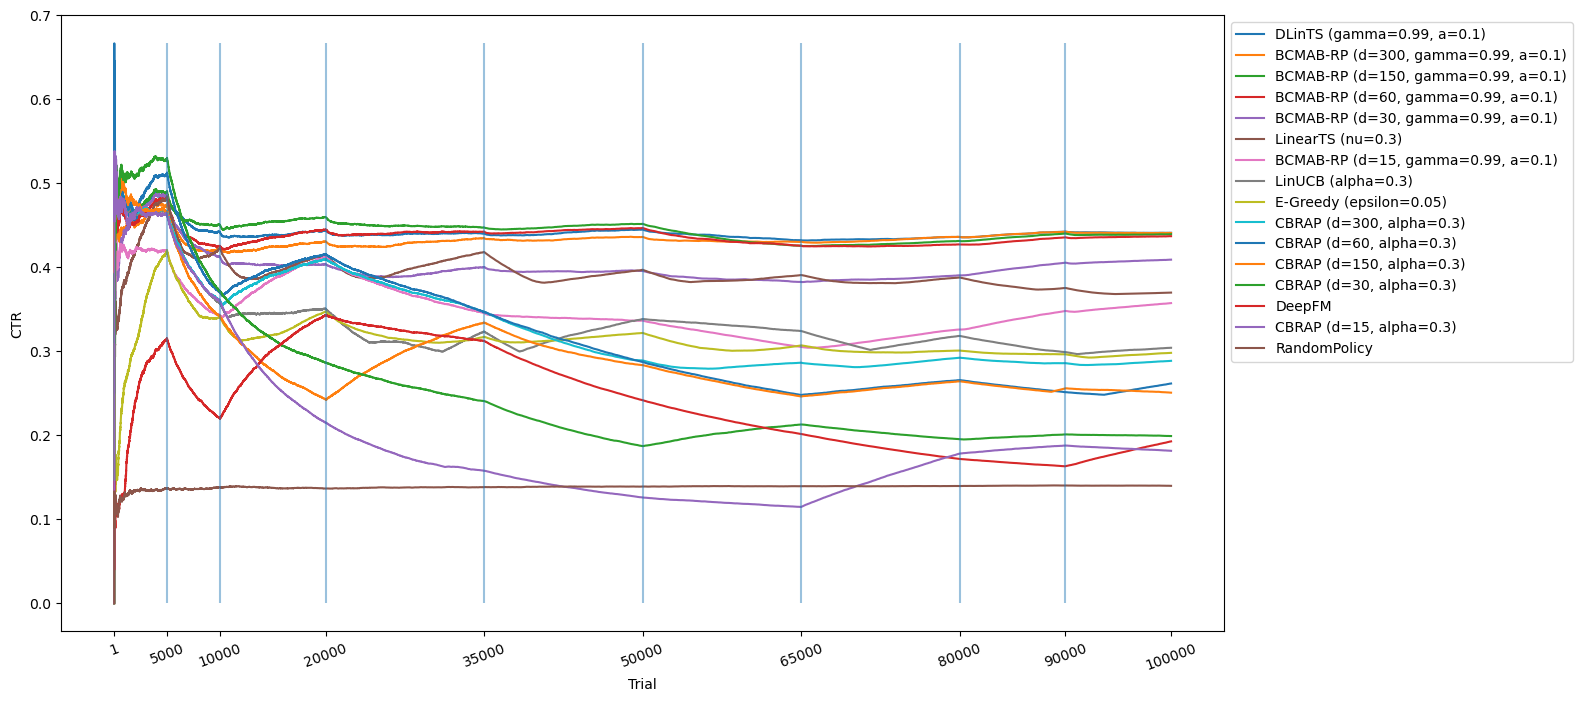

In [11]:
plot_ctrs_or_rewards(reward_dict, "CTR", CHANGE_POINTS);

In [12]:
# new_reward_dict = {}
# new_reward_dict['BCMAB-RP (d=300, gamma=0.99, a=0.1)'] = reward_dict['BCMAB-RP (d=300, gamma=0.99, a=0.1)']
# new_reward_dict['BCMAB-RP (d=150, gamma=0.99, a=0.1)'] = reward_dict['BCMAB-RP (d=150, gamma=0.99, a=0.1)']
# new_reward_dict['BCMAB-RP (d=60, gamma=0.99, a=0.1)'] = reward_dict['BCMAB-RP (d=60, gamma=0.99, a=0.1)']
# new_reward_dict['BCMAB-RP (d=30, gamma=0.99, a=0.1)'] = reward_dict['BCMAB-RP (d=30, gamma=0.99, a=0.1)']
# new_reward_dict['BCMAB-RP (d=15, gamma=0.99, a=0.1)'] = reward_dict['BCMAB-RP (d=15, gamma=0.99, a=0.1)']
# new_reward_dict['DLinTS (gamma=0.99, a=0.1)'] = reward_dict['DLinTS (gamma=0.99, a=0.1)']

In [13]:
# plot_ctrs_or_rewards(new_reward_dict, "CTR", CHANGE_POINTS);

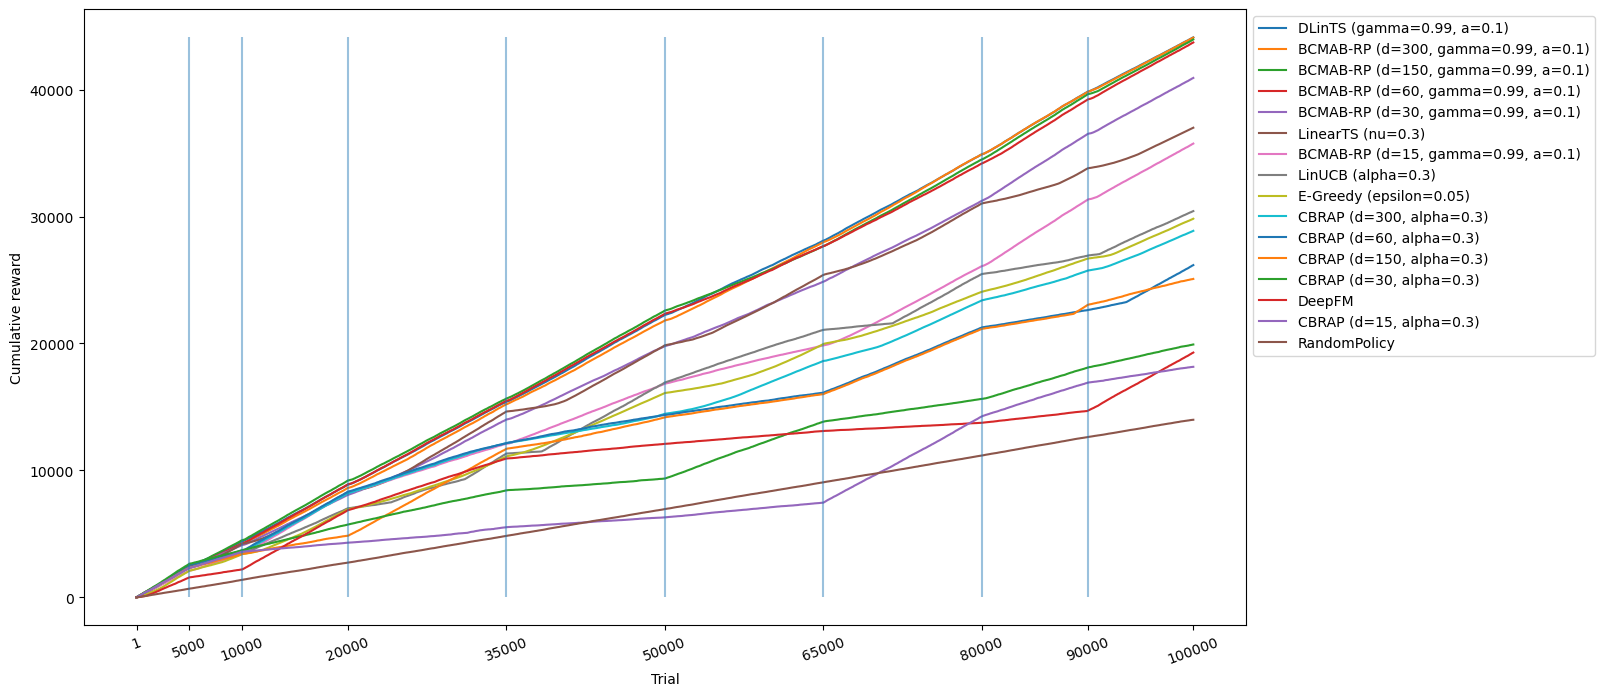

In [14]:
plot_ctrs_or_rewards(reward_dict, "Cumulative reward", CHANGE_POINTS);

In [15]:
print('Time')
{k: round(v,1) for k, v in time_dict.items()}

Time


{'CBRAP (d=150, alpha=0.3)': 893.2,
 'BCMAB-RP (d=150, gamma=0.99, a=0.1)': 2821.6,
 'RandomPolicy': 239.5,
 'LinearTS (nu=0.3)': 1881.0,
 'CBRAP (d=300, alpha=0.3)': 1017.9,
 'CBRAP (d=30, alpha=0.3)': 605.3,
 'BCMAB-RP (d=30, gamma=0.99, a=0.1)': 598.3,
 'E-Greedy (epsilon=0.05)': 467.2,
 'DLinTS (gamma=0.99, a=0.1)': 8382.4,
 'BCMAB-RP (d=60, gamma=0.99, a=0.1)': 900.9,
 'CBRAP (d=15, alpha=0.3)': 418.0,
 'BCMAB-RP (d=15, gamma=0.99, a=0.1)': 609.6,
 'LinUCB (alpha=0.3)': 820.0,
 'DeepFM': 2475.4,
 'BCMAB-RP (d=300, gamma=0.99, a=0.1)': 8588.7,
 'CBRAP (d=60, alpha=0.3)': 567.5}

In [16]:
print('Reward')
[(k,v[-1][0]) for k,v in reward_dict.items()]

Reward


[('CBRAP (d=150, alpha=0.3)', 25081.0),
 ('BCMAB-RP (d=150, gamma=0.99, a=0.1)', 43946.2),
 ('RandomPolicy', 13989.0),
 ('LinearTS (nu=0.3)', 36994.0),
 ('CBRAP (d=300, alpha=0.3)', 28870.8),
 ('CBRAP (d=30, alpha=0.3)', 19918.0),
 ('BCMAB-RP (d=30, gamma=0.99, a=0.1)', 40915.8),
 ('E-Greedy (epsilon=0.05)', 29821.2),
 ('DLinTS (gamma=0.99, a=0.1)', 44111.8),
 ('BCMAB-RP (d=60, gamma=0.99, a=0.1)', 43709.2),
 ('CBRAP (d=15, alpha=0.3)', 18159.0),
 ('BCMAB-RP (d=15, gamma=0.99, a=0.1)', 35744.2),
 ('LinUCB (alpha=0.3)', 30426.0),
 ('DeepFM', 19280.8),
 ('BCMAB-RP (d=300, gamma=0.99, a=0.1)', 44092.2),
 ('CBRAP (d=60, alpha=0.3)', 26171.0)]

In [17]:
print('NDCG')
[(k, round(v[-1][0],1)) for k,v in ndcg_dict.items()]

NDCG


[('CBRAP (d=150, alpha=0.3)', 22004.3),
 ('BCMAB-RP (d=150, gamma=0.99, a=0.1)', 32452.5),
 ('RandomPolicy', 18200.6),
 ('LinearTS (nu=0.3)', 30809.2),
 ('CBRAP (d=300, alpha=0.3)', 24117.7),
 ('CBRAP (d=30, alpha=0.3)', 18023.0),
 ('BCMAB-RP (d=30, gamma=0.99, a=0.1)', 31979.2),
 ('E-Greedy (epsilon=0.05)', 27586.9),
 ('DLinTS (gamma=0.99, a=0.1)', 33894.0),
 ('BCMAB-RP (d=60, gamma=0.99, a=0.1)', 32408.0),
 ('CBRAP (d=15, alpha=0.3)', 20113.8),
 ('BCMAB-RP (d=15, gamma=0.99, a=0.1)', 26407.6),
 ('LinUCB (alpha=0.3)', 25540.9),
 ('DeepFM', 22558.3),
 ('BCMAB-RP (d=300, gamma=0.99, a=0.1)', 34224.1),
 ('CBRAP (d=60, alpha=0.3)', 22018.0)]